# Exercise: Regression (BERN02)
Author: Hafiza Asifa Naseer 
Date: 09/09/2025 

## Method
I implemented a local regression function with tricube weights. The number of neighbors `k` was chosen by leave-one-out cross-validation (LOOCV).  

## Results
The best value of `k` was **13**.  
Predictions for mortality (MORT) at given poverty levels (POOR):  

POOR = 10 → Predicted MORT = 898.56, SE = 16.74
POOR = 18 → Predicted MORT = 955.96, SE = 15.11
POOR = 25 → Predicted MORT = 1012.24, SE = 22.93


## Visualization
The figure below shows the raw data (gray points), the fitted local regression curve (red), and its ±1 SE band (shaded). Predictions at POOR = 10, 18, and 25 are marked with blue points and error bars.  

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/pollution_cleaneddata.csv")

# Pick the variables
y = df["MORT"].to_numpy()   # response
x = df["POOR"].to_numpy()   # predictor

# sanity check
print(df[["POOR", "MORT"]].describe())

            POOR         MORT
count  60.000000    60.000000
mean   14.373333   940.358433
std     4.160096    62.206278
min     9.400000   790.733000
25%    12.000000   898.372000
50%    13.200000   943.683000
75%    15.150000   983.205750
max    26.400000  1113.156000


## local regression function

In [10]:
def tricube(u):
    u = np.asarray(u)
    out = (1 - np.abs(u)**3)**3
    out[np.abs(u) >= 1] = 0
    return out

def add_intercept(x1d):
    return np.column_stack([np.ones_like(x1d), x1d])

In [15]:
def local_simple_regression(y, x, k, x0):
    y = np.asarray(y).reshape(-1)
    x = np.asarray(x).reshape(-1)

    d = np.abs(x - x0)
    idx = np.argsort(d)[:k]
    xk, yk, dk = x[idx], y[idx], d[idx]

    dmax = dk.max()
    u = dk / dmax if dmax > 0 else dk

    w = tricube(u)
    W = np.diag(w)

    X = add_intercept(xk)
    XtWX = X.T @ W @ X
    XtWy = X.T @ W @ yk

    beta, *_ = np.linalg.lstsq(XtWX, XtWy, rcond=None)   

    h = np.array([1, x0])
    y_hat = float(h @ beta)

    resid = yk - (X @ beta)
    df = max(len(yk) - 2, 1)
    sigma2 = float((w * resid**2).sum() / df)
    var_mu = float(h @ np.linalg.pinv(XtWX) @ h)   # pseudoinverse
    se = np.sqrt(sigma2 * var_mu)

    return y_hat, se

In [16]:
df = pd.read_csv("data/pollution_cleaneddata.csv")
y = df["MORT"].to_numpy()
x = df["POOR"].to_numpy()

## Picking best k by cross-validation (LOOCV)

In [17]:
def loocv_k(y, x, k_grid):
    y = np.asarray(y)
    x = np.asarray(x)
    n = len(y)
    results = []
    for k in k_grid:
        errs = []
        for i in range(n):
            mask = np.ones(n, dtype=bool)
            mask[i] = False
            y_train, x_train = y[mask], x[mask]
            yhat, _ = local_simple_regression(y_train, x_train, k, x[i])
            errs.append((y[i] - yhat)**2)
        results.append((k, np.mean(errs)))
    results.sort(key=lambda t: t[1])
    return results[0][0], results

In [18]:
best_k, results = loocv_k(y, x, [5,7,9,11,13])
print("Best k:", best_k)
print("All results:", results)

Best k: 13
All results: [(13, np.float64(4059.4463768278065)), (11, np.float64(4138.115230646149)), (5, np.float64(4234.309800455282)), (9, np.float64(4420.95762492846)), (7, np.float64(4644.707607152345))]


## Predictions at 10, 18, 25

In [19]:
for val in [10, 18, 25]:
    pred, se = local_simple_regression(y, x, best_k, val)
    print(f"POOR = {val} → Predicted MORT = {pred:.2f}, SE = {se:.2f}")

POOR = 10 → Predicted MORT = 898.56, SE = 16.74
POOR = 18 → Predicted MORT = 955.96, SE = 15.11
POOR = 25 → Predicted MORT = 1012.24, SE = 22.93


## Plot with regression curve, CI band, and marked predictions

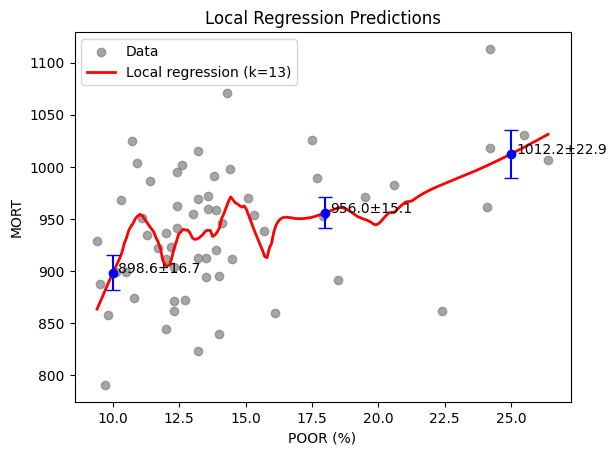

In [20]:
# Grid of POOR values
x_grid = np.linspace(x.min(), x.max(), 200)
y_pred = []
for x0 in x_grid:
    pred, _ = local_simple_regression(y, x, best_k, x0)
    y_pred.append(pred)

# Plot data + fitted curve
plt.scatter(x, y, color="gray", alpha=0.7, label="Data")
plt.plot(x_grid, y_pred, color="red", linewidth=2, label=f"Local regression (k={best_k})")

# Highlight predictions
for val in [10, 18, 25]:
    pred, se = local_simple_regression(y, x, best_k, val)
    plt.errorbar(val, pred, yerr=se, fmt="o", color="blue", capsize=5)
    plt.text(val+0.2, pred, f"{pred:.1f}±{se:.1f}")

plt.xlabel("POOR (%)")
plt.ylabel("MORT")
plt.legend()
plt.title("Local Regression Predictions")
plt.show()